In [37]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
import pandas as pd
import numpy as np
import importlib
from tqdm import tqdm
from datetime import datetime
from bs4 import BeautifulSoup 
from osgeo import gdal, osr
import copy

import helper_functions.routing.floodedRouting
importlib.reload(helper_functions.routing.floodedRouting)
import helper_functions.routing.floodedRouting as floodedRouting

# Load road network

In [26]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_car_network.graphml"
G_car = ox.load_graphml(os.path.join(save_dir,filename))

# North up image (georeferencing metadata)

- `adfGeoTransform[0]` - top left x 
- `adfGeoTransform[1]` - w-e pixel resolution 
- `adfGeoTransform[2]` - 0 
- `adfGeoTransform[3]` - top left y 
- `adfGeoTransform[4]` - 0 
- `adfGeoTransform[5]` - n-s pixel resolution (negative value) 

In [ ]:
from osgeo import gdal
# import slr 5m
slr_5m = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_SLR\Inundation_maps_5m\SGDEM36_slr_5.tif"
# slr_5m = gdal.Open(slr_5m, gdal.GA_ReadOnly)
slr_5m = gdal.Open(slr_5m)
print("Driver: {}/{}".format(slr_5m.GetDriver().ShortName,
                            slr_5m.GetDriver().LongName))
print("Size is {} x {} x {}".format(slr_5m.RasterXSize,
                                    slr_5m.RasterYSize,
                                    slr_5m.RasterCount))
print("Projection is {}".format(slr_5m.GetProjection()))
# get geotransform
geotransform5 = slr_5m.GetGeoTransform()
if geotransform5:
    print("Origin = ({}, {})".format(geotransform5[0], geotransform5[3]))
    print("Pixel Size = ({}, {})".format(geotransform5[1], geotransform5[5]))

band = slr_5m.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min_ = band.GetMinimum()
max_ = band.GetMaximum()
if not min_ or not max_:
    (min_,max_) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min_,max_))
# read as array
slr_5m_arr = np.array(slr_5m.GetRasterBand(1).ReadAsArray())

# import slr 4m
slr_4m = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_SLR\Inundation_maps\SGDEM36_slr_4.tif"
# slr_4m = gdal.Open(slr_4m, gdal.GA_ReadOnly)
slr_4m = gdal.Open(slr_4m)
print("Driver: {}/{}".format(slr_4m.GetDriver().ShortName,
                            slr_4m.GetDriver().LongName))
print("Size is {} x {} x {}".format(slr_4m.RasterXSize,
                                    slr_4m.RasterYSize,
                                    slr_4m.RasterCount))
print("Projection is {}".format(slr_4m.GetProjection()))
# get geotransform
geotransform4 = slr_4m.GetGeoTransform()
if geotransform4:
    print("Origin = ({}, {})".format(geotransform4[0], geotransform4[3]))
    print("Pixel Size = ({}, {})".format(geotransform4[1], geotransform4[5]))

band = slr_4m.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min_ = band.GetMinimum()
max_ = band.GetMaximum()
if not min_ or not max_:
    (min_,max_) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min_,max_))
# read as array
slr_4m_arr = np.array(slr_4m.GetRasterBand(1).ReadAsArray())

Driver: GTiff/GeoTIFF
Size is 1577 x 938 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (103.60570070500017, 1.4707748320001883)
Pixel Size = (0.000277690658211731, -0.0002777556194030263)


# Read as numpy

In [8]:
slr_5m = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_SLR\Inundation_maps_5m\SGDEM36_slr_5.tif"
slr_5m = gdal.Open(slr_5m)
slr_5m_arr = np.array(slr_5m.GetRasterBand(1).ReadAsArray())
slr_5m_arr.shape

(938, 1577)

# Map flooded coordinates to roadnetwork

length of flooded coord:  105624


[(905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194955, 905195330, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194955, 905194946, 0),
 (905194955, 905194946, 0),
 (905194955, 905194946, 0),
 (905195330, 905195330, 0),
 (905195330, 905195330, 0),
 (1436128853, 1436128853, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (1436128853, 1436128853, 0),
 (1436128853, 1436128853, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (905194946, 905193735, 0),
 (1436128853, 1436128853, 0),
 (1436128853, 1436128853, 0),
 (1436128853, 1436128853, 0),
 (1436128853, 1436128853, 0),
 (905194946, 905193735, 0),
 (905226688, 244489093, 0),
 (905226688, 244489093, 0),
 (905226688, 244489093, 0),
 (905226688, 244489093, 0),
 (905226688, 244489093, 0),
 (9052

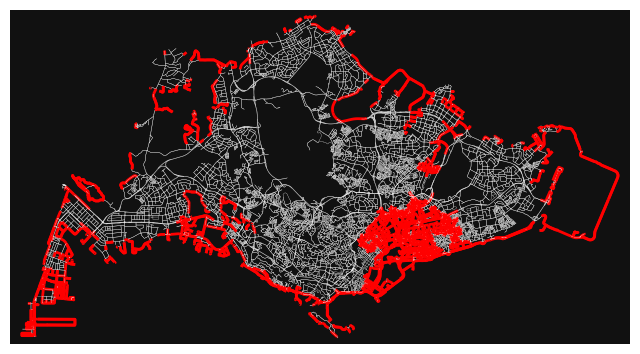

In [36]:
class UpdateCoastalFloodNetwork:
    def __init__(self, G, flooded_maxspeed=None, percentage_reduction_maxspeed=10):
        """
        Either use flooded_maxspeed or percentage_reduction_maxspeed to update flood network, one of the params must be None
        TODO: change flooded_maxspeed as a function of flood depth
        Args:
            G (G): driving route
            flooded_maxspeed (float): max speed on the road when it is flooded. Default is 20 km/h. This will override the maxspeed attribute in G.
            percentage_reduction_maxspeed (float, 0 to 100): percentage reduction from max speed allowed on roads
        """
        self.G = G
        self.flooded_maxspeed=flooded_maxspeed
        self.percentage_reduction_maxspeed = percentage_reduction_maxspeed
        # check if either one of the params is None, this is to make sure one param doesnt override the other param
        assert not(all([flooded_maxspeed != None, percentage_reduction_maxspeed != None])), "either flooded_maxspeed or percentage_reduction_maxspeed must be None"
        # to make sure both params are not None
        assert not(all([flooded_maxspeed == None, percentage_reduction_maxspeed == None])), "both flooded_maxspeed and percentage_reduction_maxspeed must not be None"
    
    def get_coastal_flood_coordinates(self,flood_arr,geotransform,flood_depth_thresh=0.15):
        """ Get indices of array where flood depth exceeds 0.15 m
        Args:
            flood_arr (np.ndarray): flood depth array in metres
            geotransform (tuple of float): GetGeoTransform() function returns tuple with 6 values (coordinates of origin, resolution, angle),
            flood_depth_thresh (np.ndarray): threshold (in metres) on the flood_arr, above this threshold, fetch the corresponding coordinates
        Returns:
            list of tuple: list of coordinates (lat,lon)
        """
        flood_idx = np.argwhere(flood_arr > flood_depth_thresh)
        def get_coords(dx,dy):
            """" 
            Args:
                dx (int): column pixel from the origin (upper left corner)
                dy (int): row pixel from the origin (upper left corner)
            """
            # origin
            px = geotransform[0]
            py = geotransform[3]
            # pixel size
            rx = geotransform[1]
            ry = geotransform[5]
            x = dx*rx + px
            y = dy*ry + py
            return y,x

        return [get_coords(idx[1],idx[0]) for idx in flood_idx]

    def identify_coastal_flooded_roads(self,flooded_coordinates, plot=True, ax = None,
                               flooded_edge_color="red",edge_color="white", flooded_edge_linewidth=2):
        """ 
        Add attribute traffic_flow to G. 
        Traffic flow Returns hourly average traffic flow, taken from a representative month of every quarter during 0700-0900 hours.
        Args:
            G (G): driving route
            flooded_coordinates (list of float tuple): [(lat,lon),(lat,lon)]
            plot (bool): if True, plot traffic volume
            ax (mpl.Axes): if None, plot on a new figure, else, plot on supplied ax
        Returns:
            list: list of edges representing flooded roads
        """
        G_copy = copy.deepcopy(self.G) # deep copy so it does not change the original
        # get nearest edges to flooded edges
        flooded_edges = ox.distance.nearest_edges(G_copy,X = [coord[1] for coord in flooded_coordinates], Y = [coord[0] for coord in flooded_coordinates])
        flooded_edges = list(flooded_edges)
        if plot:
            ec = [flooded_edge_color if e in flooded_edges else edge_color for e in self.G.edges(keys=True) ]
            ew = [flooded_edge_linewidth if e in flooded_edges else 0.2 for e in self.G.edges(keys=True) ]
            fig, ax = ox.plot_graph(
                self.G,
                node_size=0,
                edge_color = ec,
                edge_linewidth=ew,
                ax=ax,
                show = False,
                close = False
            )
        return flooded_edges

UFN = UpdateCoastalFloodNetwork(G_car, flooded_maxspeed=None, percentage_reduction_maxspeed=10)
flooded_coord = UFN.get_coastal_flood_coordinates(slr_5m_arr,geotransform,flood_depth_thresh=0.15)
print("length of flooded coord: ", len(flooded_coord))
flooded_edges = UFN.identify_coastal_flooded_roads(flooded_coord, plot=True, ax = None,
                               flooded_edge_color="red",edge_color="white", flooded_edge_linewidth=2)
flooded_edges

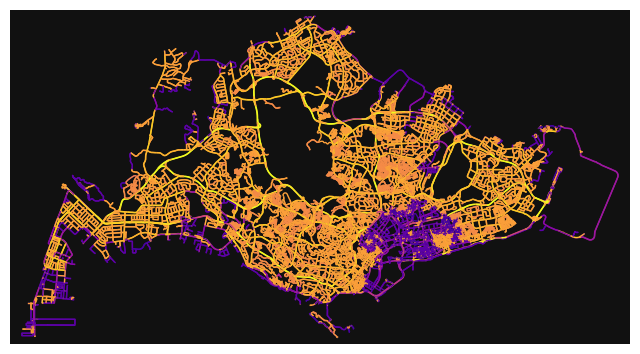

In [40]:
UFN1 = floodedRouting.UpdateFloodNetwork(G_car, flooded_maxspeed=None, percentage_reduction_maxspeed=80)
UFN1.update_flooded_road_network(flooded_edges, plot=True,cmap="plasma",node_size=0)

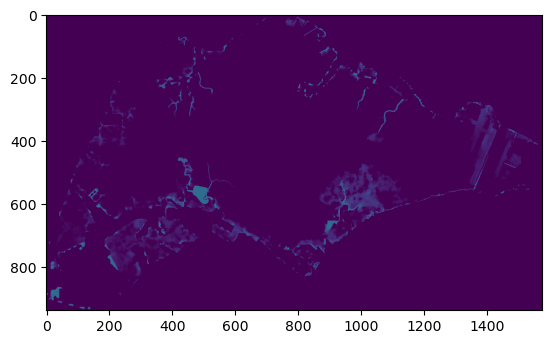

In [9]:
plt.imshow(slr_5m_arr)